## Artist Recommendation System using Collaborative Filtering

### The Objective of this notebook is to:

- Examine the data we are working with by performing initial Exploratory Data Analysis (EDA)
- Build a couple versions of a basic collaborative recommender system:
    - K Nearest Neighbors in sci-kit learn
    
    
We will only be using the Number of plays by users because we are recommending artists - artist recommendation system

# System Design

## Collaborative Filtering - Recommendation System

- We get artist plays given in file usersha1-artmbid-artname-plays.tsv
- We get user profile data given in the file usersha1-profile.tsv
- Merge the data and convert it into sparse matrix of the form
  
|   |User1|User2| .... |UserN|
|---|---|---|---| ---|
|Artist1|np|np|np|np|
|Artist2|np|np|np|np|
|...|...|...|...|...|
|ArtistN|np|np|np|np|
  
- We apply k-Nearest Neighbhor Algorithm with Cosine as distance measure (k-Nearest Neighbhor is supervised Machine Learning technique
- Get the recommendations of artist
- Get recommendations of users as per their artist they have watched

# Concerns if put in production

There are two main issues/ concerns which needs to be handle before the production

1. This model will not work for new users, when some new user comes the model needs to be update
2. The matrix created for recommendation system is very large, this gives memory error when modeling. This can be handle using some distributed environment such as PySpark

# Advantages
1. Easy to deploy this model as service
2. kNN algo with Cosine make this a strong model
3. This model can be easily scaled for new users and new artists

# Python Important Module

In [1]:
# Sometime due to warnings there is difficulty in reading Output, this will remove warning messages
import warnings
warnings.filterwarnings("ignore")

# check kernel environment
import sys
print("Kernel: {}".format(sys.executable))

# Core data analysis packages
import pandas as pd
import numpy as np

# For our EDA charts
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Compressed Sparse Row ("CSR") matrix
from scipy.sparse import csr_matrix 

# use K-Nearest Neighbors to find cosine distance amongst artists
from sklearn.neighbors import NearestNeighbors

# fuzzy string matching to allow for differing spelling of artist names
from fuzzywuzzy import fuzz, process

# import os to use operating system functionality 
import os


# set output to three decimals
pd.set_option('display.float_format',lambda x: '%.2f' %x)

# set seed for reproducibility of random number initializations
seed = np.random.RandomState(seed=42)


Kernel: C:\Users\work\AppData\Local\Continuum\anaconda3\envs\FTDS\python.exe


# Downloading the dataset & loading our files

- I have used the Last.fm dataset in order to build an artist recommendation system.

- You need to download dataset from this <a href="http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html">link</a>

- Put dataset inside the data folder.

In [2]:
paths=os.path.normpath(os.getcwd())+"\\data\\lastfm-dataset-360K"
print("Put your datasets inside this folder: "+paths)

Put your datasets inside this folder: C:\Users\work\OneDrive\Documents\Work\Laura\Github\Decathlon-Assignment\Q4-Recommendation-System\data\lastfm-dataset-360K


In [3]:
# Path where all files are kept
os.listdir(paths)

['mbox_sha1sum.py',
 'README.txt',
 'usersha1-artmbid-artname-plays.tsv',
 'usersha1-profile.tsv']

In [4]:
# import our files
plays = pd.read_csv(paths+r"\usersha1-artmbid-artname-plays.tsv",sep="\t", header=None)
profiles = pd.read_csv(paths+r"\usersha1-profile.tsv",sep="\t", header=None)

# Set Columns names from README.txt file

In [5]:
plays.columns = ["user-mboxsha1", "musicbrainz-artist-id", "artist-name", "plays"]
plays.head(5)

,user-mboxsha1,musicbrainz-artist-id,artist-name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [6]:
profiles.columns = ["user-mboxsha1", "gender", "age", "country", "signup_date"]
profiles.head(5)

,user-mboxsha1,gender,age,country,signup_date
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.00,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.00,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.00,United States,"Jan 27, 2006"


In [7]:
profiles.isna().sum()

user-mboxsha1        0
gender           32775
age              74900
country              0
signup_date          0
dtype: int64

In [8]:
profiles["country"].nunique()

239

As we can see above, the user_data is not perfect and we have a significant null value for ages and also gender. Even if we combine these null values as "other" category, it does not improve the model. For country there are 239 uniques values.

# Show Basic Information about Datasets

In [9]:
# create a function to provide various statistics on our data files
def print_info(df_list, df_name):
    
    # assertion to ensure our two lists are equal in length (ie we didn"t make any mistakes)
    assert len(df_list) == len(df_name)

    for i in range(len(df_list)):
        print(df_name[i],"\n")
        print("Shape: {}\n".format(df_list[i].shape))
        print("Info:")
        print(df_list[i].info(),"\n")
        print("Unique:\n{}\n".format(df_list[i].nunique()))     
        
        # This returns True if no duplicates are dropped (ie duplicates do not exist)
        print("No duplicates: {}\n".format(len(df_list[i])==len(df_list[i].drop_duplicates())))

In [10]:
df_list = [plays, profiles]
df_name = ["**Plays**", "**Profiles**"]
print_info(df_list,df_name)

**Plays** 

Shape: (17535655, 4)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17535655 entries, 0 to 17535654
Data columns (total 4 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   user-mboxsha1          object
 1   musicbrainz-artist-id  object
 2   artist-name            object
 3   plays                  int64 
dtypes: int64(1), object(3)
memory usage: 535.1+ MB
None 

Unique:
user-mboxsha1            358868
musicbrainz-artist-id    160112
artist-name              292363
plays                     14159
dtype: int64

No duplicates: True

**Profiles** 

Shape: (359347, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359347 entries, 0 to 359346
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user-mboxsha1  359347 non-null  object 
 1   gender         326572 non-null  object 
 2   age            284447 non-null  float64
 3   country        359347 non

# Merge User Profile and Plays Data

In [11]:
ap = pd.merge(plays, 
              profiles, 
              how="inner",
              on="user-mboxsha1")
ap.head(5)

,user-mboxsha1,musicbrainz-artist-id,artist-name,plays,gender,age,country,signup_date
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,f,22.00,Germany,"Feb 1, 2007"
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099,f,22.00,Germany,"Feb 1, 2007"
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897,f,22.00,Germany,"Feb 1, 2007"
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717,f,22.00,Germany,"Feb 1, 2007"
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706,f,22.00,Germany,"Feb 1, 2007"


# Artist ranking

Here we are ranking the artist according to their unique users, total plays in that artist and average users per play. This ranking will help us in recommendations in later stages.


Here we will derive further valuable information from our dataset, including:

- Per user/artist pair:
    - Plays. This is our play count data; the amount of plays of one artist by one user.

- Per artist:
    - Total Artist Plays. Aggregate play count of all users of a single artist.
    - Total Unique Users. Aggregate users who have listened to an artist at least once.
    - Average User Plays. Average times the artist was played by the unique user. Calculated as Total Artist Plays / Total Unique Users.

- Per user:
    - Total User Plays. Aggregate plays of all artist by a single user.
    - Total Unique Artists. The number of artist data available for a single user (the dataset apparently caps this at 50).

In [12]:
artist_rank = (ap.groupby(["artist-name"]).agg({"user-mboxsha1":"count","plays":"sum"}).
    rename(columns={"user-mboxsha1":"totalUniqueUsers","plays":"totalArtistPlays"}).
              sort_values(["totalArtistPlays"],ascending=False))

artist_rank["avgUserPlays"] = artist_rank["totalArtistPlays"]/artist_rank["totalUniqueUsers"]

user_rank = (ap.groupby(["user-mboxsha1"]).agg({"artist-name":"count","plays":"sum"}).
    rename(columns={"artist-name":"totalUniqueArtists","plays":"totalUserPlays"}).
            sort_values(["totalUserPlays"],ascending=False))

In [13]:
# "the beatles" Spears is the most played at 30,466,827 (30 Miilions) plays
artist_rank.head(5)

,totalUniqueUsers,totalArtistPlays,avgUserPlays
artist-name,,,
the beatles,76245,30466827,399.59
radiohead,77253,27426222,355.02
coldplay,66658,16686772,250.33
pink floyd,44443,15943557,358.74
metallica,45233,15481852,342.27


# The basic statistics

In [14]:
artist_rank.describe()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
count,292363.00,292363.00,292363.00
mean,59.98,12907.00,138.04
std,672.47,185981.46,264.34
min,1.00,1.00,1.00
25%,1.00,53.00,36.00
50%,2.00,208.00,88.00
75%,8.00,1048.00,168.00
max,77253.00,30466827.00,36285.00


In [15]:
# Top users in term of play count
user_rank.head(5)

,totalUniqueArtists,totalUserPlays
user-mboxsha1,,
0ebecedb3cef2347ebab2936d30c1a488b8c43d0,56,787884
8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,48,568011
710183e9a50e4bd8ad61b24ac4b287f03d51b322,58,539942
f27c8d76cf15dd6e79fec7affb684804475292de,48,474080
92aa9c188586c2e57dfa76326ee8b8bdd62dd426,50,461744


For convenience, we will join our artist and user data into a single table. As such, we will need to be careful when deriving insights from columns.

In [16]:
ap2 = ap.join(artist_rank,on="artist-name",how="inner")
ap3 = ap2.join(user_rank,on="user-mboxsha1",how="inner").sort_values(["plays"],ascending=False)

In [17]:
ap3.head(5)

,user-mboxsha1,musicbrainz-artist-id,artist-name,plays,gender,age,country,signup_date,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
9654928,8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,dcaa4f81-bfb7-44eb-8594-4e74f004b6e4,nofx,419157,m,31.00,Austria,"Nov 11, 2005",10471,5025614,479.96,48,568011
1435231,14ea4c6f3c2e86b4937f1158bd13d3173d780bd7,5e6c760b-42e0-4df4-a221-0269355da00a,dean martin,288375,f,NaN,United States,"Apr 26, 2006",2594,655025,252.52,19,320326
12624418,b88d16f3ebdad0bf701ecd46cf4725ea31911849,40f5d9e4-2de7-4f2d-ad41-e31a9a9fea27,the smiths,272359,m,38.00,Brazil,"Apr 5, 2006",21274,6408712,301.25,50,428354
5155710,4b79df05a80b733e6422e52e5d1f25b50cd3aadb,ab309b83-904f-4e2c-8d11-a0223bba51f9,dir en grey,270122,m,23.00,Japan,"May 19, 2007",3705,2814331,759.60,42,436498
12784050,baee6143fb184f2014f05c737c28cd57d6d0486f,79239441-bfd5-4981-a70c-55c3f15c1287,madonna,242328,m,31.00,Brazil,"May 1, 2007",25469,7633843,299.73,52,271825


In [18]:
# 3 billion total plays
print("{:,}".format(ap3["plays"].sum()))

3,773,528,520


# Visualizations

In [19]:
# our standard bar chart in a function below

def bar_chart_int(x,y,x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x[:20], y[:20], palette="PuRd")
    ax.set_xlabel(x_label,fontweight="bold")
    ax.set_ylabel(y_label,fontweight="bold")
    ax.set_title(title,fontweight="bold")
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: "{:,}".format(int(x))))

    # our bar label placement
    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                "{:1.1f}%".format(pct),
                ha="center",verticalalignment="bottom",color="black") 

    # our caption statement
    ax.text(19, max(y[:20])*0.95, caption, style="italic",fontsize=12,horizontalalignment="right")

    plt.xticks(rotation=90)
    plt.show()

With **30466827** plays out of a aggregate play count of **3,773,528,520** in the dataset, **The Beatles** received 0.8% of the plays in the dataset.

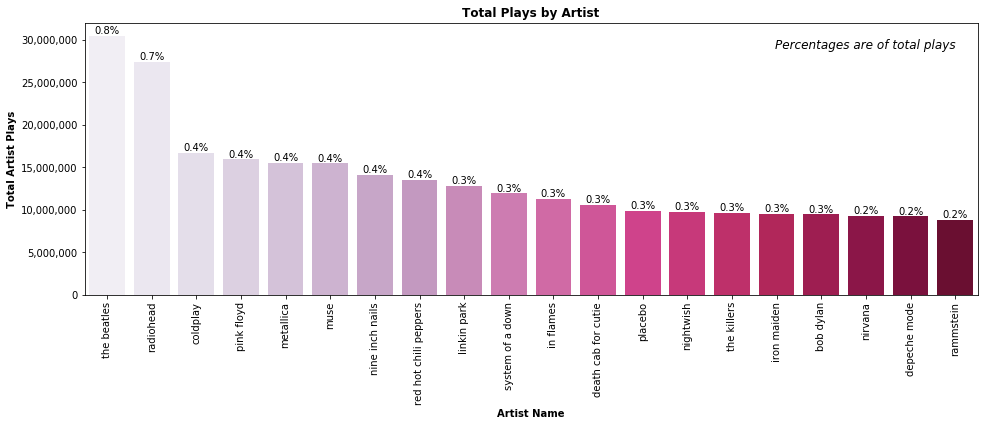

In [20]:
c1 = artist_rank
x = c1.index
y = c1.totalArtistPlays
x_label = "Artist Name"
y_label = "Total Artist Plays"
title = "Total Plays by Artist"
caption = "Percentages are of total plays"
total_val = c1.totalArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [21]:
artist_rank.sort_values(["totalUniqueUsers"],ascending=False).head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
artist-name,,,
radiohead,77253,27426222,355.02
the beatles,76245,30466827,399.59
coldplay,66658,16686772,250.33
red hot chili peppers,48924,13547741,276.91
muse,46954,15451683,329.08


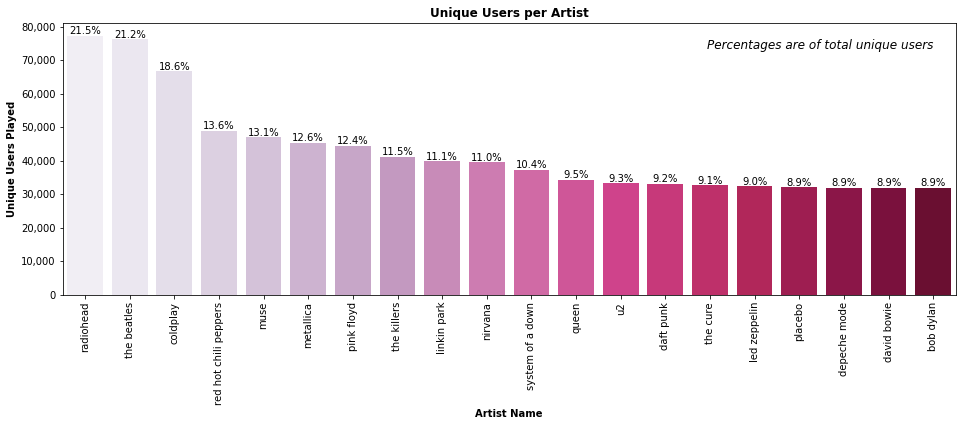

In [22]:
c2 = artist_rank.sort_values(["totalUniqueUsers"],ascending=False)
x = c2.index
y = c2.totalUniqueUsers
x_label = "Artist Name"
y_label = "Unique Users Played"
title = "Unique Users per Artist"
caption = "Percentages are of total unique users"
total_val = ap3["user-mboxsha1"].nunique()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

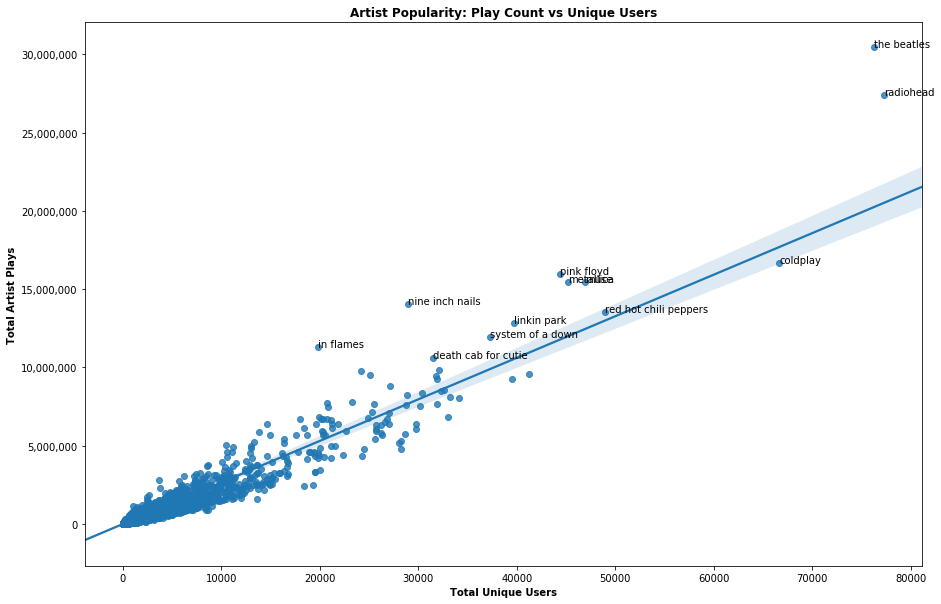

In [23]:
top_artists = artist_rank.sort_values(["totalArtistPlays"],ascending=False).index[:12]

x = artist_rank.totalUniqueUsers
y = artist_rank.totalArtistPlays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x,y)
ax.set_title("Artist Popularity: Play Count vs Unique Users",fontweight="bold")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:,.0f}".format(y)))
ax.set_xlabel("Total Unique Users",fontweight="bold")
ax.set_ylabel("Total Artist Plays",fontweight="bold")

for i, t in enumerate(labels):
    if t in top_artists:
        ax.annotate(t,(x[i],y[i]))

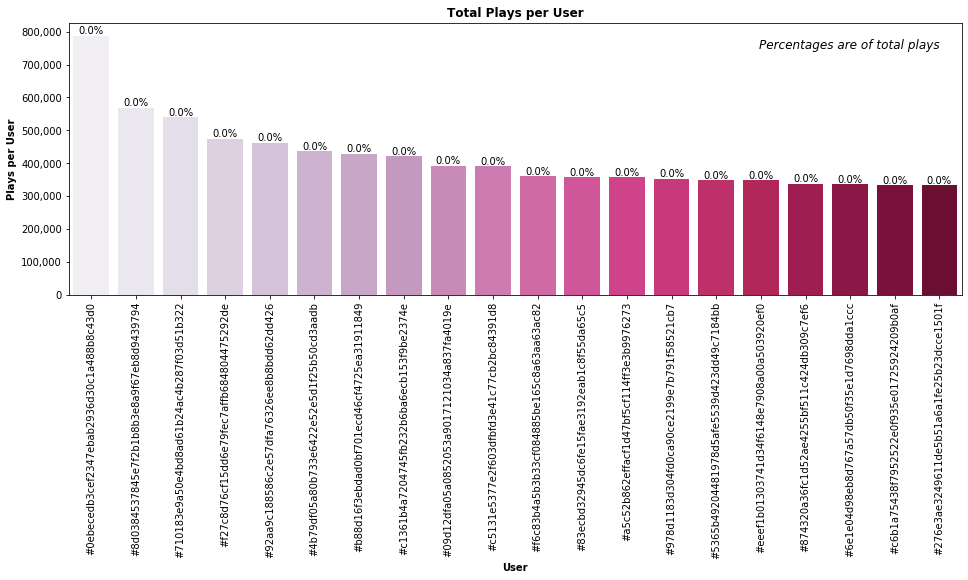

In [24]:
# Contribution of each user - contribution is less than 1 becuase of huge dataset
c3 = user_rank.sort_values(["totalUserPlays"],ascending=False)
c3["user-mboxsha1"] = c3.index
c3["user-mboxsha1"] = c3["user-mboxsha1"].apply(lambda x: "#"+str(x))

x = c3["user-mboxsha1"]
y = c3.totalUserPlays
x_label = "User"
y_label = "Plays per User"
title = "Total Plays per User"
caption = "Percentages are of total plays"
total_val = ap3.plays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [25]:
artist_rank.sort_values(["avgUserPlays"],ascending=False).head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
artist-name,,,
Макс иванов,1,36285,36285.00
mr. silakka,1,32366,32366.00
coca cola christmas,1,27604,27604.00
2brother,1,23675,23675.00
big lonz,1,22202,22202.00


In [26]:
ap3[ap3["artist-name"]=="coca cola christmas"]

,user-mboxsha1,musicbrainz-artist-id,artist-name,plays,gender,age,country,signup_date,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
2911499,2a8f828c08d6737cd9bcdd762348060c07d557f8,NaN,coca cola christmas,27604,m,23.00,Norway,"Aug 2, 2004",1,27604,27604.00,50,114418


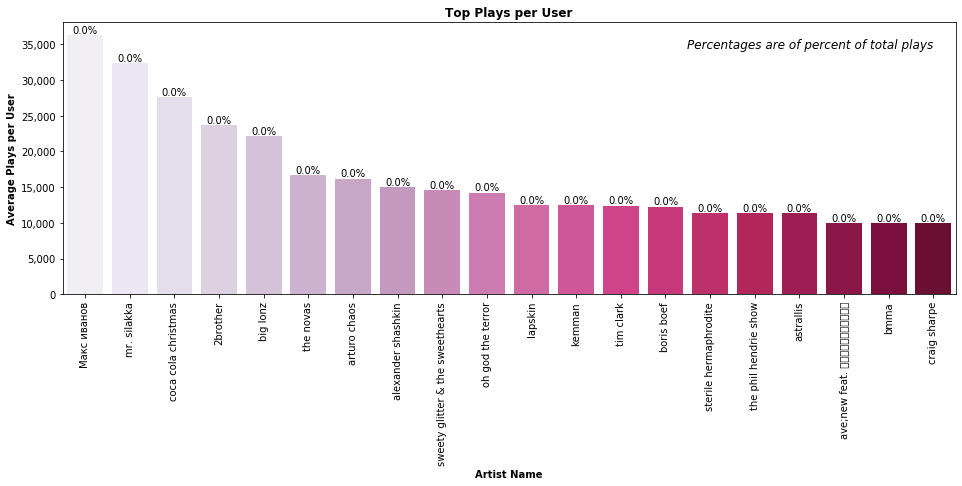

In [27]:
c4 = artist_rank.sort_values(["avgUserPlays"],ascending=False)

x = c4.index
y = c4.avgUserPlays
x_label = "Artist Name"
y_label = "Average Plays per User"
title = "Top Plays per User"
caption = "Percentages are of percent of total plays"
total_val = ap3.plays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

If we include only popular artists which we will define as over 100 unique users, it will gives us the most dedicated fans

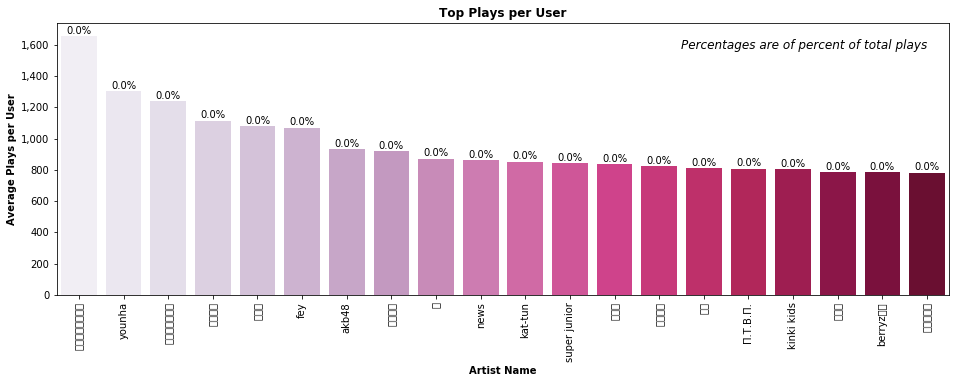

In [28]:
c5 = artist_rank[artist_rank["totalUniqueUsers"]>100].sort_values(["avgUserPlays"],ascending=False)

x = c5.index
y = c5.avgUserPlays
x_label = "Artist Name"
y_label = "Average Plays per User"
title = "Top Plays per User"
caption = "Percentages are of percent of total plays"
total_val = ap3.plays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)


# Item Similarity with K-Nearest Neighbors in Scikit Learn

As our first iteration of a basic collaborative recommender, we will build a sparse matrix comparing artist plays (rows) by user (columns). This data will then be passed through a latent mapping algorithm, K-nearest neighbors, to determine cosine similarity amongst the user/artist relationships. This will help us determine which artists are most similar as in shortest distance apart within this latent mapping. For instance, as we would see with a relatively small cosine distance between them, when a user plays **clawfinger**, they also have a high probability of playing the **godsmack** rather than a more distant artist such as Snoop Dogg.

# Prepare Sparse Matrix
Here we fit data into a sparse matrix of artist name (row) vs. user (column). This matrix captures all relationships between artists and users with number of plays in each respective cell.

|   |User1|User2| .... |UserN|
|---|---|---|---| ---|
|Artist1|np|np|np|np|
|Artist2|np|np|np|np|
|...|...|...|...|...|
|ArtistN|np|np|np|np|

Where **np** is number of plays

Example

|   |User1|User2|user3|User4|
|---|---|---|---| ---|
|Artist1|5|2|2|0|
|Artist2|0|2|2|1|
|Artist3|0|1|0|0|
|Artist4|0|1|0|0|
|Artist5|0|0|0|1|

In [29]:
# fit data into a sparse matrix of artist name (row) vs user (column)
# in terms of number of plays by artist/user
def data_to_sparse(data,index,columns,values):
    pivot = data.pivot(index=index,columns=columns,values=values).fillna(0)
    sparse = csr_matrix(pivot.values)
    print(sparse.shape)
    return pivot, sparse

# User K Nearest Neighbors to determine cosine distance amongst artists
def fit_knn(sparse):
    knn = NearestNeighbors(metric="cosine")
    knn.fit(sparse)
    print(knn)
    return knn

## Talking sample of data to avoid memory issues

In [30]:
ap4 = ap3.head(1000)

In [31]:
pivot_ap3,sparse_ap3 = data_to_sparse(ap4,index="artist-name",columns="user-mboxsha1",values="plays")

(576, 859)


In [32]:
knn = fit_knn(sparse_ap3)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)


In [33]:
pivot_ap3.head(5)

user-mboxsha1,0033ee7378661b88b245b1f67cc622ff63a51061,006261139d787c1e43b4c69d304f2772367c1005,006c8ca50e7700a7744b4e18a4c0cad7e2dc5592,00a20b9791abd8b29903a8a43e343ae93a98d9fd,00eaf1e508d9078dbd99f9a93f26ccdf41ed78ce,0104a80a31d821a13e08e24f80dc30c62cd65191,01d84708f851f7257a34aa5040eac0fd5a5e38d5,024a218c1c7b0516f4831a1cfbba266002142144,025e476b4e8f4aec3bf263c737b65fd856acd0c2,0268c4ff8eba994c93fc0e49644bac7b49caa068,...,fd66aac4f86b222d6d4cb7bffbe690c3b4b81213,fdb5b5b698b62621da1d65a4907a10208c09d39c,feb88a480c59569d53940d617854fff98a487f20,fede7413abf6a1e53557756e43bdd913caa2b420,ff128f44ada4ecafd06438e4ec39181634650ccd,ff2ce775eaf0c90569a7c6cd4a1c8f458df12e57,ff4b19c43528846b3c2cbdf5434fa8a3ea5875df,ff654604ed06a095bd8d95ac0e4508e0b83cac6e,ffba5496d4a7ea01f70b05806a8689d6f25d777b,ffbbd9e0a6c65bf15f076e8c97fe9c94cdfe456c
artist-name,,,,,,,,,,,,,,,,,,,,,
2 playaz,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
213,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2brother,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2pac,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30 seconds to mars,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [34]:
def idx_recommend(data,idx,model,k):
    distances, indices = (model.kneighbors(data.
                                     iloc[idx,:]. #filter on specific row=artist
                                     values.reshape(1,-1), #reshape to get users in columns and plays in 1 row                                                                       #Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
                                     n_neighbors=k+1))

    for i in range(0,len(distances.flatten())):
        if i == 0:
            print(("Recommendations for {}:\n".
                  format(data.index[idx])))
        else:
            print(("{}: {} ({:.3f})".
                  format(i,
                         data.index[indices.flatten()[i]],
                         distances.flatten()[i])))
    return ""



In [35]:
# we query a random artist
query_index = seed.choice(pivot_ap3.shape[0])
idx_recommend(pivot_ap3,query_index,knn,6)

Recommendations for clover studio:

1: pink floyd (1.000)
2: phyllis hyman (1.000)
3: poets of the fall (1.000)
4: pig destroyer (1.000)
5: phish (1.000)
6: pretty ricky (1.000)


''

In [36]:
# lookup index number for select artists
query_index = pivot_ap3.index.get_loc("the beatles")
idx_recommend(pivot_ap3,query_index,knn,6)

Recommendations for the beatles:

1: perfume (0.717)
2: bruce springsteen & the e street band (0.814)
3: they might be giants (0.858)
4: bruce springsteen (0.892)
5: oasis (0.923)
6: queen (0.937)


''

# Query by Artist (with Fuzzy Matching)
Here we implement direct artist lookup using fuzzy matching for partial name matches.

In [37]:
# this will help us to locate partial matches of our query
def fuzzy_match(query_subject,data):
    ratio_tuples = []
    
    # each artist name is the subject in the data index
    # each artist in the data is compared against our query subject to determine percentage match
    # NOTE there may be ways to optimize this process by not looping through all artists
    for subject in data.index:
        ratio = fuzz.ratio(subject.lower(),query_subject.lower())
        current_query_idx = data.index.tolist().index(subject)
        ratio_tuples.append((subject, ratio,current_query_idx))
        
    # our findings are then sorted based on match rating, and top two are kept
    ratio_tuples = sorted(ratio_tuples, key=lambda tup: tup[1],reverse=True)[:2]
    
    print("Top matches: {}\n".format([(x[0],x[1]) for x in ratio_tuples]))  
    
    match = ratio_tuples[0][0]
    
    return match, ratio_tuples

def artist_recommend(query_artist, data, model,k):
    
    # determine artist matches using fuzzy matching
    
    match, ratio_tuples = fuzzy_match(query_artist,data)
    
    # look up artist by query index
    idx_recommend(data, ratio_tuples[0][2],model,k)   
    
    return ""

In [38]:
artist_recommend("hammer",pivot_ap3,knn,10)

Top matches: [('hammerfall', 75), ('hans zimmer', 71)]

Recommendations for hammerfall:

1: placebo (1.000)
2: poets of the fall (1.000)
3: phil hendrie (1.000)
4: phish (1.000)
5: phyllis hyman (1.000)
6: pig destroyer (1.000)
7: pink floyd (1.000)
8: perfume (1.000)
9: pulp (1.000)
10: queens of the stone age (1.000)


''

# Feature Scaling: Apply Threshold
Here we apply thresholds to keep only popular artists and active users. This reduces noise in our data in an aim to improve our recommendations.

We will filter as follows.

- Users:
    - Minimum Plays per User. Minimum aggregate play count per user.
    - Minimum Unique Artist Plays. A user needs to play at least this many different artists to be counted.
- Artists:
    - Minimum Artist Plays. Minimum times an artist must be played.
    - Minimum Listeners. Minimum unique users per artist.

In [39]:
minPlaysPerUser = 1000 # minimum aggregate play count per user
minUniqueArtistPlays = 10 # minimum different artists that need values per user to be counted
minArtistPlays = 10000 # minimum times an artist must be played
minListeners = 10 # minimum unique listeners of artist to be played

def apply_threshold(data,
                    minPlaysPerUser,
                    minUniqueArtistPlays,
                    minArtistPlays,
                    minListeners):
    
    filtered = (data[(data["totalUserPlays"]>=minPlaysPerUser) & 
               (data["totalUniqueArtists"]>=minUniqueArtistPlays) & 
               (data["totalArtistPlays"]>=minArtistPlays) & 
               (data["totalUniqueUsers"]>=minListeners)])

    # confirm our min thresholds have been applied
    print("MINIMUM VALUES")
    print("totalUserPlays from {} to {}".format(min(data.totalUserPlays),min(filtered.totalUserPlays)))
    print("totalUniqueArtists from {} to {}".format(min(data.totalUniqueArtists),min(filtered.totalUniqueArtists)))
    print("totalArtistPlays from {} to {}".format(min(data.totalArtistPlays),min(filtered.totalArtistPlays)))
    print("totalUniqueUsers from {} to {}".format(min(data.totalUniqueUsers),min(filtered.totalUniqueUsers)))

    print("\nFILTER IMPACT")
    print("FILTERED Users: {} Artists: {}".format(len(filtered["user-mboxsha1"].unique()),
                                                           len(filtered["artist-name"].unique())))
    print("ORIGINAL Users: {} Artists: {}".format(len(data["user-mboxsha1"].unique()),
                                                           len(data["artist-name"].unique())))
    print("FILTERED % ORIGINAL Users: {:.1f}% Artists: {:.1f}%".format(100*(len(filtered["user-mboxsha1"].unique())/len(data["user-mboxsha1"].unique())),
                                                           100*(len(filtered["artist-name"].unique())/len(data["artist-name"].unique()))))
    return filtered

ap5 = apply_threshold(ap3,minPlaysPerUser,minUniqueArtistPlays,minArtistPlays,minListeners)

ap5[["totalUserPlays","totalUniqueArtists","totalArtistPlays","totalUniqueUsers"]].describe()

MINIMUM VALUES
totalUserPlays from 1 to 1000
totalUniqueArtists from 1 to 10
totalArtistPlays from 1 to 10000
totalUniqueUsers from 1 to 10

FILTER IMPACT
FILTERED Users: 316315 Artists: 22082
ORIGINAL Users: 358866 Artists: 292363
FILTERED % ORIGINAL Users: 88.1% Artists: 7.6%


,totalUserPlays,totalUniqueArtists,totalArtistPlays,totalUniqueUsers
count,14259623.00,14259623.00,14259623.00,14259623.00
mean,12268.81,50.89,2308361.81,8655.02
std,15500.59,7.96,4056935.24,12661.74
min,1000.00,10.00,10000.00,10.00
25%,3752.00,47.00,159764.00,847.00
50%,7716.00,49.00,760769.00,3376.00
75%,15035.00,54.00,2573320.00,11078.00
max,787884.00,166.00,30466827.00,77253.00


In [40]:
ap6 = ap5.head(10000)
pivot_ap4, sparse_ap4 = data_to_sparse(ap6,index="artist-name",columns="user-mboxsha1",values="plays")
knn_ap4 = fit_knn(sparse_ap4)

(3053, 6551)
NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)


In [41]:
artist_recommend("hammerfall",pivot_ap4, knn_ap4,10)

Top matches: [('hammerfall', 100), ('the fall', 67)]

Recommendations for hammerfall:

1: rob zombie (0.374)
2: teräsbetoni (0.528)
3: rhapsody (0.585)
4: power quest (0.720)
5: altaria (0.720)
6: arcturus (0.720)
7: primal fear (0.720)
8: smokie (0.720)
9: timeless miracle (0.720)
10: rainbow (0.760)


''

# Recommend Artists to Users

In [42]:
some_user = "00001411dc427966b17297bf4d69e7e193135d89"


# lookup index number for select artists
def Artist_recommend(data,idx,model,k):
    distances, indices = (model.kneighbors(data.
                                     iloc[idx,:].
                                     values.reshape(1,-1),
                                     n_neighbors=k+1))

    return data.index[indices.flatten()].tolist(), distances.flatten().tolist()

def recommendArtistToUser(userID, topN=5):
    
    artists = []
    done = []
    
    # extract plays of that user
    plays_of_user = plays[plays["user-mboxsha1"] == userID]
    for u in plays_of_user["artist-name"].values.tolist():
        
        try:
            query_index = pivot_ap3.index.get_loc(u)
            names, scores = Artist_recommend(pivot_ap3,query_index,knn,6)
            
            for i in range(len(names)):
                if names[i] != u and names[i] not in done:
                    artists.append([scores[i], names[i]])
                    done.append(names[i])
        except:
            continue
    del done
    return sorted(artists,key=lambda l:l[0], reverse=False)[0:topN]
            
recommendArtistToUser(some_user, topN=5)

[[0.0, 'bill frisell'],
 [0.2435975911946313, 'pulp'],
 [0.8034464658804411, 'daniel powter'],
 [0.9369757054744379, 'the beatles'],
 [1.0, 'phyllis hyman']]

In [ ]:
#output as file w top1 for every user in df